<a href="https://colab.research.google.com/github/Shaam93/Building-a-classifer-with-Pytorch/blob/master/Classifier_Using_sampler_Google_Drive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install Pillow==5.3.0

In [0]:
!pip install torch torchvision

In [0]:
import torch
print("torch version: ", torch.__version__)
import PIL
print("pillow version: ", PIL.PILLOW_VERSION)

torch version:  1.0.1.post2
pillow version:  5.3.0


In [0]:
import time
import copy
from PIL import Image
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable
#import torch
#import PIL
import json
from torch import nn, optim
from torch.optim import lr_scheduler
from torchvision import transforms, models, datasets

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#removed the validation directory
#we also no longer need the data directory here
train_dir = 'gdrive/My Drive/testing Colab/train'
#valid_dir = 'valid'
test_dir= 'gdrive/My Drive/testing Colab/test'


dirs = {'train': train_dir,
        #'valid': valid_dir, 
        'test' : test_dir
       }

In [0]:
# add transforms to the data
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
        
                             
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                            [0.229, 0.224, 0.225])
    ]),
}

In [0]:
from torch.utils.data.sampler import SubsetRandomSampler
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32
# percentage of training set to use as validation
valid_size = 0.2
#removed the validation set to use the sampler
image_datasets = {x: datasets.ImageFolder(dirs[x],   transform=data_transforms[x]) for x in ['train', 'test']}
#dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True) for x in ['train', 'test']}


In [0]:
# obtain training indices that will be used for validation
num_train = len(image_datasets['train'])
print('origional train dataset size ', num_train) 
indices = list(range(num_train))

np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
print('the new train dataset size:', len(train_idx))
print('the new validation dataset size:', len(valid_idx))
test_idx = [i for i in range(len(image_datasets['test']))]
print('the test imagedataest size', len(image_datasets['test']))

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size,
    drop_last= True, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, 
    drop_last= True, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size, 
    drop_last= True,sampler=test_sampler,num_workers=num_workers)

print('length of train loader', len(train_loader))
print('length of valid loader', len(valid_loader))
print('length of test loader', len(test_loader))

print('length of train_sampler', len(train_sampler))
print('length of valid_sampler', len(valid_sampler))
print('length of test_sampler', len(test_sampler))



origional train dataset size  6552
the new train dataset size: 5242
the new validation dataset size: 1310
the test imagedataest size 819
length of train loader 163
length of valid loader 40
length of test loader 25
length of train_sampler 5242
length of valid_sampler 1310
length of test_sampler 819


In [0]:
class_names = image_datasets['train'].classes
print(class_names)

['1', '10', '100', '101', '102', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


In [0]:
with open('gdrive/My Drive/testing Colab/cat_to_name.json', 'r') as f:
    label_map = json.load(f)

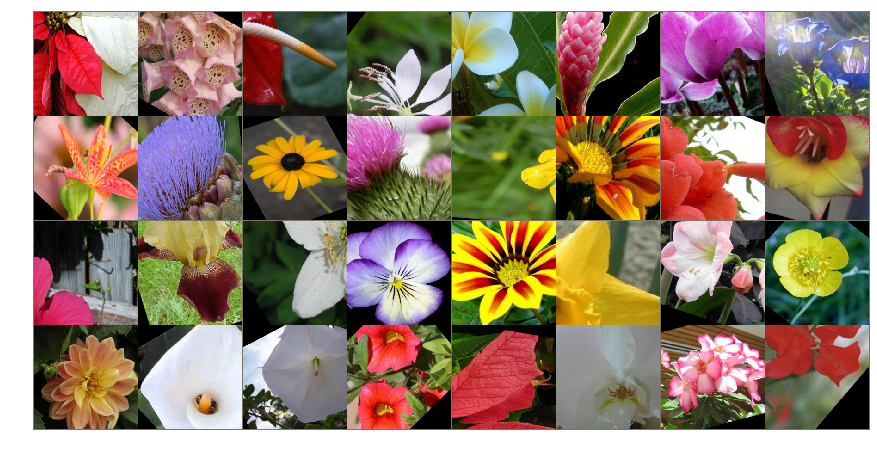

In [0]:
import torchvision
import matplotlib.pyplot as plt
def imshow(image):
    if isinstance(image, torch.Tensor):
        image = image.numpy().transpose((1, 2, 0))
    else:
        image = np.array(image).transpose((1, 2, 0))
    # Unnormalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    plt.imshow(image)
    ax.axis('off') 
        
images, _ = next(iter(train_loader))
out = torchvision.utils.make_grid(images, nrow=8)
imshow(out)

In [0]:
# choose the model
model = models.resnet18(pretrained=True)

In [0]:
num_ftrs = model.fc.in_features
# change the outputs from 512 to 102
model.fc = nn.Linear(num_ftrs, 102)

In [0]:
#unfreezing your model (for better accuracy)
for param in model.parameters():
    param.requires_grad = True

In [0]:
#moveing to GPU
model.cuda()


In [0]:
def train_model(model, criteria, optimizer, scheduler,    
                                      num_epochs=25, device='cuda'):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs ))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criteria(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
criteria = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
# Number of epochs
eps=5


In [0]:
#the actual training/validating 
model = train_model(model, criteria, optimizer, scheduler, eps, 'cuda')

In [0]:
#Saving the checkpoint 
model.class_to_idx = image_datasets['train'].class_to_idx
model.cpu()
torch.save({
            'state_dict': model.state_dict(),
             
            'class_to_idx': model.class_to_idx}, 
            "/content/gdrive/My Drive/classifier.pth")
#torch.save(model.sate_dict, "/content/gdrive/My Drive/classifier.pt")